In [ ]:
# MUST upload 'database.sqlite' file included when running the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import sqlite3
from sklearn.metrics import mean_squared_error

%matplotlib inline

SEED = 10
np.random.seed(SEED)

In [ ]:
# match_data.csv has been included which can directly be imported
# instead of creating this file again using this code.
# This part of the code also produces the same file, however, takes ~35 mins to finish execution
# hence it might be easier to directly import the submitted match_data.csv.
conn = sqlite3.connect('database.sqlite')

# Load Match data
match_df = pd.read_sql_query("""
SELECT
    id,
    date,
    home_team_api_id,
    away_team_api_id,
    home_player_1,
    home_player_2,
    home_player_3,
    home_player_4,
    home_player_5,
    home_player_6,
    home_player_7,
    home_player_8,
    home_player_9,
    home_player_10,
    home_player_11,
    away_player_1,
    away_player_2,
    away_player_3,
    away_player_4,
    away_player_5,
    away_player_6,
    away_player_7,
    away_player_8,
    away_player_9,
    away_player_10,
    away_player_11,
    home_team_goal,
    away_team_goal
FROM Match
""", conn)
player_df = pd.read_sql_query("""
SELECT
    player_api_id,
    overall_rating,
    potential,
    attacking_work_rate,
    defensive_work_rate,
    crossing,
    finishing,
    heading_accuracy,
    short_passing,
    volleys,
    dribbling,
    curve,
    free_kick_accuracy,
    long_passing,
    ball_control,
    acceleration,
    sprint_speed,
    agility,
    reactions,
    balance,
    shot_power,
    jumping,
    stamina,
    strength,
    long_shots,
    aggression,
    interceptions,
    positioning,
    vision,
    penalties,
    marking,
    standing_tackle,
    sliding_tackle,
    gk_diving,
    gk_handling,
    gk_kicking,
    gk_positioning,
    gk_reflexes
FROM Player_Attributes
""", conn)



# Function to get home and away players for a specific match_id
def get_players_for_match(match_row):
    # Extract home players
    home_players = [match_row[f'home_player_{i}'] for i in range(1, 12)]

    # Extract away players
    away_players = [match_row[f'away_player_{i}'] for i in range(1, 12)]

    return home_players, away_players

# Function to get the last 5 games of a given team
def get_last_5_games(date, team_api_id, match_df):
    target_date = pd.to_datetime(date)
    target_year = target_date.year

    # Convert the match_df 'date' column to datetime if not already
    match_df['date'] = pd.to_datetime(match_df['date'])

    # Filter for matches in the same year and before the target date
    filtered_matches = match_df[
        ((match_df['home_team_api_id'] == team_api_id) |
         (match_df['away_team_api_id'] == team_api_id)) &
        (match_df['date'] < target_date) &
        (match_df['date'].dt.year == target_year)
    ]


    # Sort by date descending and take the last 5 matches
    recent_matches = filtered_matches.sort_values(by='date', ascending=False).head(5)
    return recent_matches


# Function to get the last 5 losses of a team given its id and last 5 games
def get_last_5_losses(team_api_id, recent_matches):
    # Convert input date to datetime and extract the year
    losses = 0
    for _, row in recent_matches.iterrows():
        if row['home_team_api_id'] == team_api_id and row['home_team_goal'] < row['away_team_goal']:
            losses += 1
        elif row['away_team_api_id'] == team_api_id and row['away_team_goal'] < row['home_team_goal']:
            losses += 1

    return losses

# Function to get the last goals scored in the last 5 games of a team given its id and its last 5 games
def get_last_5_gf(team_api_id, recent_matches):
    gf = 0
    for _, row in recent_matches.iterrows():
        # If team is home team, add home_team_goal to gf
        if row['home_team_api_id'] == team_api_id:
            gf += row['home_team_goal']
        else:
            gf += row['away_team_goal']

    return gf

# Function to get the goals conceded by a team in the last 5 games
def get_last_5_ga(team_api_id, recent_matches):
    ga = 0
    for _, row in recent_matches.iterrows():
        # If team is home team, add home_team_goal to gf
        if row['home_team_api_id'] == team_api_id:
            ga += row['away_team_goal']
        else:
            ga += row['home_team_goal']

    return ga


def get_avg_stats(player_df, players):
    """
    Given a DataFrame of player attributes (player_df) and a list of player IDs (players),
    return the average stats for each attribute across the given players, with work rates
    converted to numeric values (1 = Low, 2 = Medium, 3 = High).

    If a work rate is missing, it will be treated as 'Medium' (value 2).
    """
    # Filter the player_df to include only the rows where player_api_id is in the players list
    filtered_df = player_df[player_df['player_api_id'].isin(players)]

    # Map work rates to numeric values
    work_rate_mapping = {'low': 1, 'medium': 2, 'high': 3}

    # Fill missing work rate values with 'Medium' (value 2)
    filtered_df['attacking_work_rate'] = filtered_df['attacking_work_rate'].fillna('medium').map(work_rate_mapping)
    filtered_df['defensive_work_rate'] = filtered_df['defensive_work_rate'].fillna('medium').map(work_rate_mapping)

    # Calculate the average of each column (excluding 'player_api_id')
    avg_stats = filtered_df.drop(columns=['player_api_id']).mean()

    avg_stats_df = avg_stats.to_frame().T  # Transpose to make it a single-row DataFrame

    return avg_stats_df

# Function to get the home team in a given match
def get_home_away_team(match_row):
    home_team_id = match_row['home_team_api_id']
    away_team_id = match_row['away_team_api_id']
    return home_team_id, away_team_id

# Function to get the date of a given match
def get_match_date(match_row):
    date = pd.to_datetime(match_row['date']).date()  # removes timestamp
    return str(date)  # returns 'YYYY-MM-DD' as string


# Calculate the goal difference between home and away team
def calculate_goal_difference(match_row):
    return match_row['home_team_goal'] - match_row['away_team_goal']

# Main function to process all matches and create a CSV
def process_matches_to_csv(match_df, player_df, output_file='match_data.csv'):
    # List to hold the data for all matches
    match_data = []

    # Iterate over all matches in the match_df
    for match_id in match_df['id']:
        match_row = match_df[match_df['id'] == match_id].iloc[0]
        home_team_id, away_team_id = get_home_away_team(match_row)
        date = get_match_date(match_row)

        # Get home team's last 5 games
        home_team_last_5 = get_last_5_games(date, home_team_id, match_df)
        # Get home team's last 5 losses
        home_team_last_5_losses = get_last_5_losses(home_team_id, home_team_last_5)
        # Get goals scored by home team in last 5 games
        home_team_gf = get_last_5_gf(home_team_id, home_team_last_5)
        # Get goals conceded by home team in last 5 games
        home_team_ga = get_last_5_ga(home_team_id, home_team_last_5)


        # Get away team's last 5 games
        away_team_last_5 = get_last_5_games(date, away_team_id, match_df)
        # Get away team's last 5 losses
        away_team_last_5_losses = get_last_5_losses(away_team_id, away_team_last_5)
        # Get goals scored by away team in the last 5 games
        away_team_gf = get_last_5_gf(away_team_id, away_team_last_5)
        # Get goals conceded by away team in the last 5 games
        away_team_ga = get_last_5_ga(away_team_id, away_team_last_5)


        # Get players for the current match
        home_players, away_players = get_players_for_match(match_row)

        # Get the average stats for home players
        home_avg_stats = get_avg_stats(player_df, home_players)

        # Get the average stats for away players
        away_avg_stats = get_avg_stats(player_df, away_players)

        # Calculate the goal difference
        goal_diff = calculate_goal_difference(match_row)

        # Determine if the home team won
        if goal_diff > 0:
            home_team_win = 1  # Home team wins
        elif goal_diff < 0:
            home_team_win = 0  # Away team wins
        else:
            home_team_win = 2  # Draw

        # Only add stats if data is available for home and away players
        if(not home_avg_stats.isna().all(axis=1).any() and not away_avg_stats.isna().all(axis=1).any()):
            match_row = [match_id,
                        match_df.loc[match_df['id'] == match_id, 'home_team_api_id'].values[0],
                        match_df.loc[match_df['id'] == match_id, 'away_team_api_id'].values[0]] + \
                        home_avg_stats.values.flatten().tolist() + \
                        away_avg_stats.values.flatten().tolist() + \
                        [goal_diff, home_team_win, home_team_last_5_losses, home_team_gf, home_team_ga, away_team_last_5_losses, away_team_gf, away_team_ga]

            # Append the match row to match_data
            match_data.append(match_row)

    # Convert match_data into a DataFrame
    columns = ['match_id', 'home_team_api_id', 'away_team_api_id'] + \
              [f'home_{col}' for col in home_avg_stats.columns] + \
              [f'away_{col}' for col in away_avg_stats.columns] + ['goal_diff' , 'home_team_win', 'home_team_last_5_losses',
                                                                   'home_team_gf', 'home_team_ga', 'away_team_last_5_losses', 'away_team_gf', 'away_team_ga']
    match_data_df = pd.DataFrame(match_data, columns=columns)

    # Write the DataFrame to a CSV file
    match_data_df.to_csv(output_file, index=False)
    print(f"Match data saved to {output_file}")

# Call the function to process all matches and save to CSV
process_matches_to_csv(match_df, player_df)


Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['attacking_work_rate'] = filtered_df['attacking_work_rate'].fillna('medium').map(work_rate_mapping)
<ipython-input-2-d5dc6b8c2ee3>:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['defensive_work_rate'] = filtered_df['defensive_work_rate'].fillna('medium').map(work_rate_mapping)
<ipython-input-2-d5dc6b8c2ee3>:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

Match data saved to match_data.csv


In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load data
df = pd.read_csv("match_data.csv")

# Features and target
X = df.drop(columns=["match_id", "home_team_win", "goal_diff"])
y_goal_diff = df["goal_diff"]
y_home_team_win = df["home_team_win"]

# Drop rows with NaN values from both X and y
X = X.dropna()
# y_home_team_win = y_home_team_win[X.index]  # Ensure y has the same indices as X after dropping NaNs
# list(X.columns)




GOAL DIFFERENCE PREDICTION

In [4]:
# Split data into train and test sets (for goal difference prediction)
y_goal_diff = y_goal_diff[X.index]  # Ensure y has the same indices as X after dropping NaNs
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(X, y_goal_diff, test_size=0.2, random_state=42)
X_train_norm_diff = (X_train_diff - X_train_diff.mean()) / X_train_diff.std()
X_test_norm_diff = (X_test_diff - X_train_diff.mean()) / X_train_diff.std()  # Use X_train stats for normalization

In [6]:
from sklearn.linear_model import LinearRegression
import numpy as np
import math


model = LinearRegression()
model.fit(X_train_norm_diff, y_train_diff)

y_pred_diff = model.predict(X_test_norm_diff)
# Round decimal values to nearest integer prediction
# Only round up if prediction is greater than 0.8, else round down
y_pred_diff_rounded = np.where(
    y_pred_diff > 0.8,
    np.ceil(y_pred_diff),
    np.where(y_pred_diff < 0, np.floor(y_pred_diff), np.round(y_pred_diff))
)

mse = mean_squared_error(y_test_diff, y_pred_diff_rounded)
print(f"MSE: {mse}")
print(f"RMSE: {math.sqrt(mse)}")
print(f"R2: {model.score(X_test_norm_diff, y_test_diff)}")


MSE: 2.8048780487804876
RMSE: 1.6747770146441847
R2: 0.20355595581708608


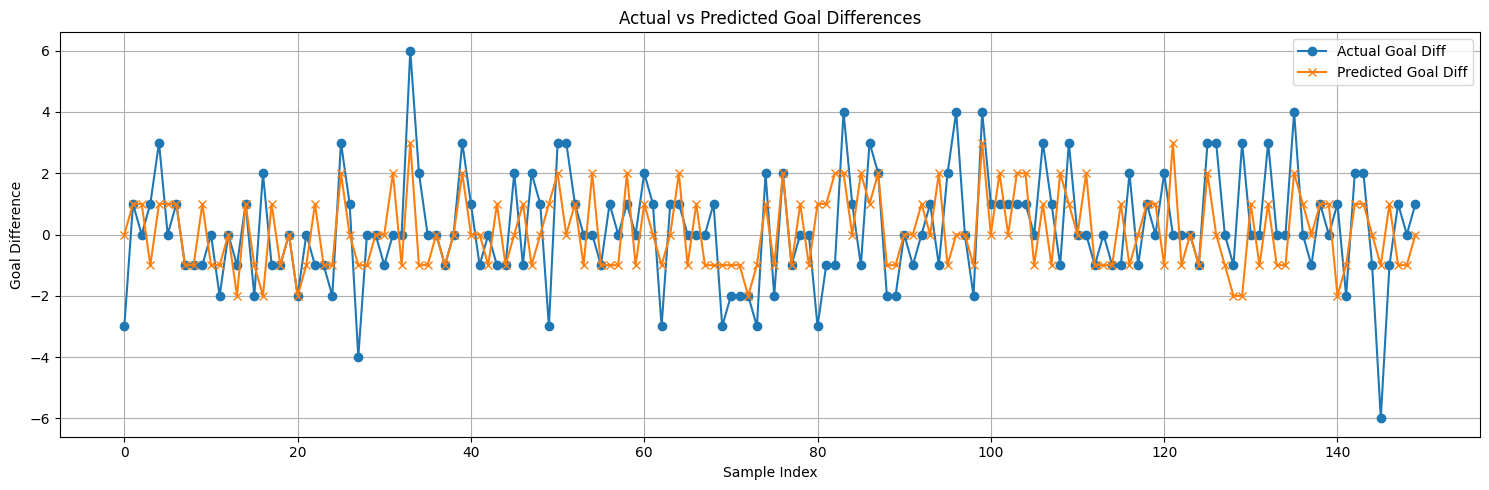

In [7]:
import matplotlib.pyplot as plt
import numpy as np


y_test_array = np.array(y_test_diff)
y_pred_array = np.array(y_pred_diff_rounded)

N = 150
plt.figure(figsize=(15, 5))
plt.plot(y_test_array[:N], label="Actual Goal Diff", marker='o')
plt.plot(y_pred_array[:N], label="Predicted Goal Diff", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Goal Difference")
plt.title("Actual vs Predicted Goal Differences")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train_norm_diff, y_train_diff)

y_pred_diff = model.predict(X_test_norm_diff)
# Round decimal values to nearest integer prediction
# Only round up if prediction is greater than 0.8, else round down
y_pred_diff_rounded = np.where(
    y_pred_diff > 0.8,
    np.ceil(y_pred_diff),
    np.where(y_pred_diff < 0, np.floor(y_pred_diff), np.round(y_pred_diff))
)

mse = mean_squared_error(y_test_diff, y_pred_diff_rounded)
print(f"MSE: {mse}")
print(f"RMSE: {math.sqrt(mse)}")
print(f"R2: {model.score(X_test_norm_diff, y_test_diff)}")

MSE: 2.7864366448542532
RMSE: 1.6692623055871876
R2: 0.19843759121114302


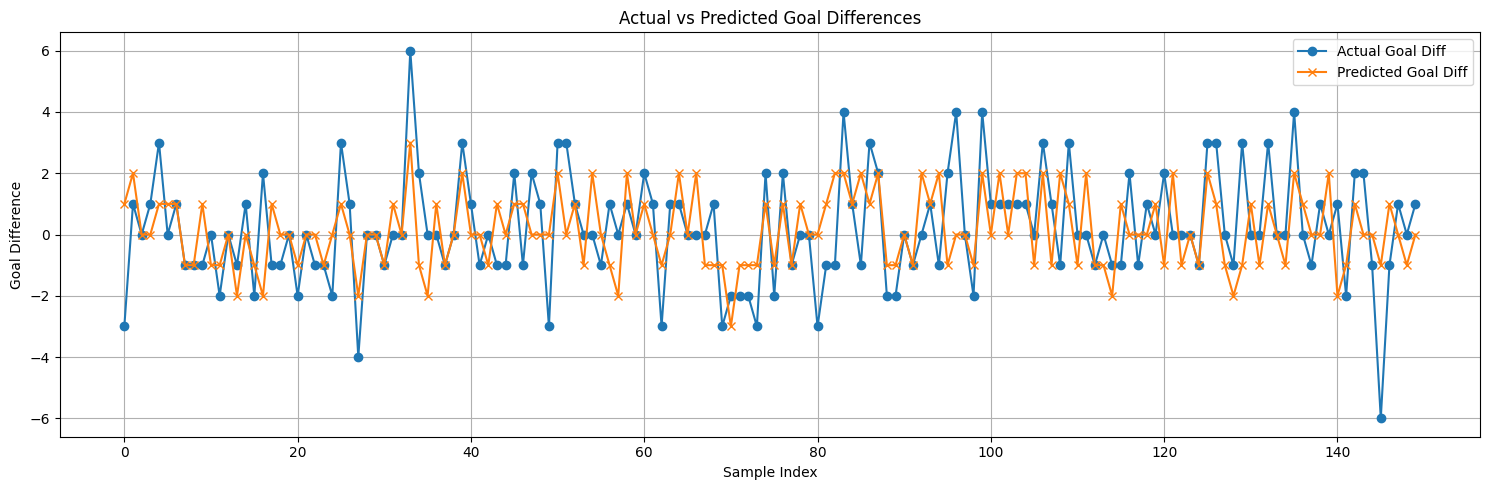

In [9]:
import matplotlib.pyplot as plt
import numpy as np

y_test_array = np.array(y_test_diff)
y_pred_array = np.array(y_pred_diff_rounded)

N = 150
plt.figure(figsize=(15, 5))
plt.plot(y_test_array[:N], label="Actual Goal Diff", marker='o')
plt.plot(y_pred_array[:N], label="Predicted Goal Diff", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Goal Difference")
plt.title("Actual vs Predicted Goal Differences")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


WINNER PREDICTION

In [5]:
# Split data into train and test sets (for winner prediction)
y_home_team_win = y_home_team_win[X.index]  # Ensure y has the same indices as X after dropping NaNs
y_home_team_win = y_home_team_win.map(lambda x: 1 if x == 1 or x == 2 else 0)

X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(X, y_home_team_win, test_size=0.2, random_state=42)
X_train_norm_win = (X_train_win - X_train_win.mean()) / X_train_win.std()
X_test_norm_win = (X_test_win - X_train_win.mean()) / X_train_win.std()  # Use X_train stats for normalization

In [3]:
# CODE TAKEN FROM HW3
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

Cs = [10 ** i for i in range(-5, 6)] # TODO: fill in the hyper-parameter candidates

c_accuracy_points = []

for c in Cs:
  lsvc = LinearSVC(random_state = 7, C = c, dual=False)
  # TODO: Fit the model and get prediction and evalutation on testing data.

  lsvc.fit(X_train_norm_win, y_train_win)

  # TODO: Save your results

  y_pred_win = lsvc.predict(X_test_norm_win)

  accuracy = accuracy_score(y_test_win, y_pred_win)
  print(f"Accuracy for C = {c}: {accuracy}")

  c_accuracy_points.append((c, accuracy))


Accuracy for C = 1e-05: 0.7005750545310331
Accuracy for C = 0.0001: 0.7328970850684117
Accuracy for C = 0.001: 0.7307158437438033
Accuracy for C = 0.01: 0.7301209597461829
Accuracy for C = 0.1: 0.7307158437438033
Accuracy for C = 1: 0.7311124330755503
Accuracy for C = 10: 0.7313107277414238
Accuracy for C = 100: 0.7313107277414238
Accuracy for C = 1000: 0.7313107277414238
Accuracy for C = 10000: 0.7313107277414238
Accuracy for C = 100000: 0.7313107277414238


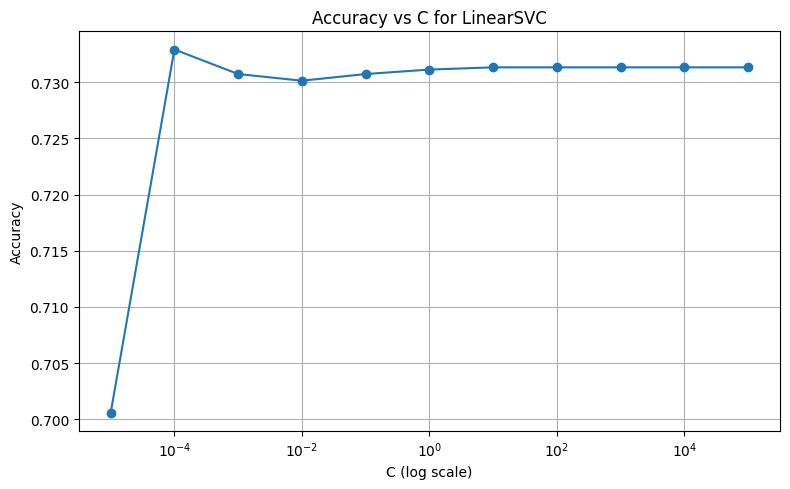

In [4]:
# CODE TAKEN FROM HW3
import matplotlib.pyplot as plt

# Split c_accuracy_points into separate lists
c_values, accuracies = zip(*c_accuracy_points)

plt.figure(figsize=(8, 5))
plt.plot(c_values, accuracies, marker='o')
plt.xscale('log')  # Log scale because Cs are powers of 10
plt.xlabel('C (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C for LinearSVC')
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# CODE TAKEN FROM HW3
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


n_trees = [10, 100, 500, 1000]

rf_accuracy_points = []

for n in n_trees:
  rf = RandomForestClassifier(random_state = 7, n_estimators=n)

  rf.fit(X_train_norm_win, y_train_win)


  rf_pred_win = rf.predict(X_test_norm_win)

  rf_accuracy = accuracy_score(y_test_win, rf_pred_win)

  print(f"Accuracy for {n} trees: {rf_accuracy}")

  rf_accuracy_points.append((n, rf_accuracy))


n_values, rf_accuracy_values = zip(*rf_accuracy_points)

Accuracy for 10 trees: 0.6920483838984731
Accuracy for 100 trees: 0.7317073170731707
Accuracy for 500 trees: 0.7313107277414238
Accuracy for 1000 trees: 0.7293277810826889


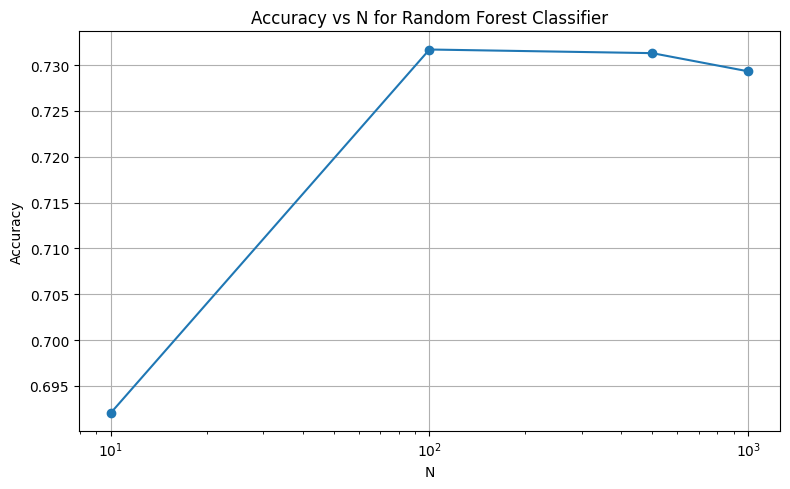

In [8]:
# CODE TAKEN FROM HW3
import matplotlib.pyplot as plt

n_values, accuracies = zip(*rf_accuracy_points)

plt.figure(figsize=(8, 5))
plt.plot(n_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.title('Accuracy vs N for Random Forest Classifier')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# CODE TAKEN FROM HW3
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


gammas = [10 ** i for i in range(-1, 5)]

gamma_accuracy_points = []

for g in gammas:
  rsvc = SVC(random_state = 7, C=1.0, kernel='rbf', gamma = g)


  rsvc.fit(X_train_norm_win, y_train_win)

  rsvc_pred = rsvc.predict(X_test_norm_win)

  rsvc_accuracy = accuracy_score(y_test_win, rsvc_pred)

  print(f"Accuracy for gamma = {g}: {rsvc_accuracy}")

  gamma_accuracy_points.append((g, rsvc_accuracy))




Accuracy for gamma = 0.1: 0.711877850485822
Accuracy for gamma = 1: 0.7031528851873885
Accuracy for gamma = 10: 0.7031528851873885
Accuracy for gamma = 100: 0.7031528851873885
Accuracy for gamma = 1000: 0.7031528851873885
Accuracy for gamma = 10000: 0.7031528851873885


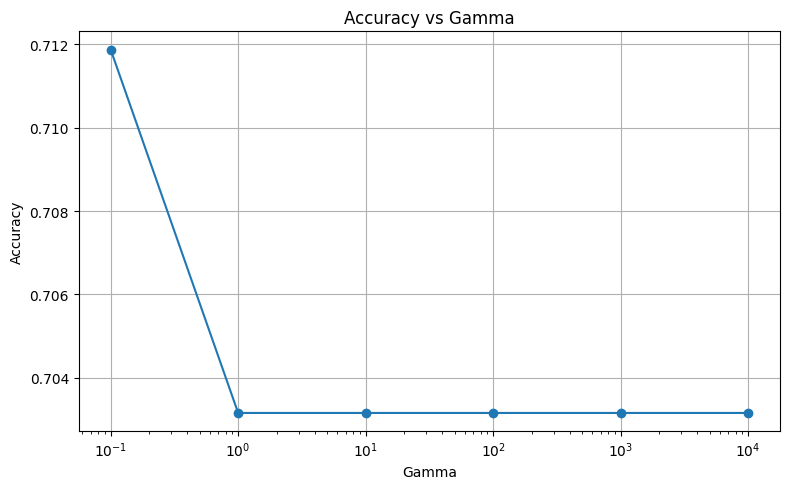

In [9]:
# CODE TAKEN FROM HW3
import matplotlib.pyplot as plt

g_values, accuracies = zip(*gamma_accuracy_points)

plt.figure(figsize=(8, 5))
plt.plot(g_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# All possible k values (76 features in total)
k_values = [i for i in range(2, 77)]
accuracies = []

for k in k_values:
    pca = PCA(n_components=k)
    # Find pca components
    x_train_transformed = pca.fit_transform(X_train_norm_win)
    # Project test set onto the learnt components
    x_test_transformed = pca.transform(X_test_norm_win)

    # Train logistic regression model on reduced dimension x
    clf = LogisticRegression(max_iter=100000)
    clf.fit(x_train_transformed, y_train_win)

    # Predict on tranformed test data
    y_pred = clf.predict(x_test_transformed)
    acc = accuracy_score(y_test_win, y_pred)
    accuracies.append(acc)
    print(f"Accuracy for k = {k}: {acc:.4f}")



Accuracy for k = 2: 0.7162
Accuracy for k = 3: 0.7174
Accuracy for k = 4: 0.7176
Accuracy for k = 5: 0.7216
Accuracy for k = 6: 0.7252
Accuracy for k = 7: 0.7260
Accuracy for k = 8: 0.7273
Accuracy for k = 9: 0.7271
Accuracy for k = 10: 0.7271
Accuracy for k = 11: 0.7281
Accuracy for k = 12: 0.7277
Accuracy for k = 13: 0.7277
Accuracy for k = 14: 0.7287
Accuracy for k = 15: 0.7279
Accuracy for k = 16: 0.7289
Accuracy for k = 17: 0.7287
Accuracy for k = 18: 0.7281
Accuracy for k = 19: 0.7287
Accuracy for k = 20: 0.7297
Accuracy for k = 21: 0.7285
Accuracy for k = 22: 0.7266
Accuracy for k = 23: 0.7285
Accuracy for k = 24: 0.7279
Accuracy for k = 25: 0.7283
Accuracy for k = 26: 0.7283
Accuracy for k = 27: 0.7289
Accuracy for k = 28: 0.7281
Accuracy for k = 29: 0.7275
Accuracy for k = 30: 0.7293
Accuracy for k = 31: 0.7277
Accuracy for k = 32: 0.7285
Accuracy for k = 33: 0.7291
Accuracy for k = 34: 0.7283
Accuracy for k = 35: 0.7291
Accuracy for k = 36: 0.7299
Accuracy for k = 37: 0.7303


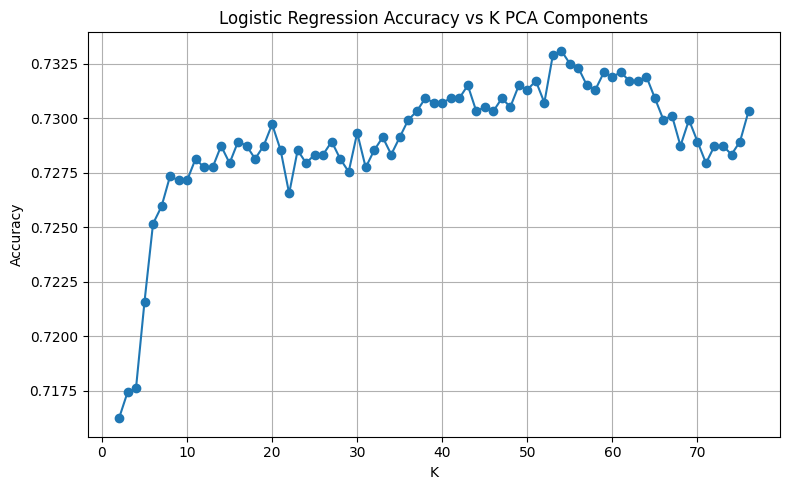

In [12]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs K PCA Components')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train_norm_win, y_train_win)
y_pred = log_reg.predict(X_test_norm_win)
acc = accuracy_score(y_test_win, y_pred)
print(acc)

0.7334919690660321


In [5]:
# CODE TAKEN FROM HW3
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

n_folds = 5

# configure the cross-validation procedure
cv = KFold(n_splits=n_folds, shuffle=True, random_state=1)


space_a = {'C': [10 ** i for i in range(-5, 6)]}
space_b = {'gamma': [10 ** i for i in range(-1, 5)]}
space_c = {'n_estimators': [10, 100, 500, 1000]}


lsvc = LinearSVC(random_state = 7, dual = False)
rsvc = SVC(random_state = 7, C=1.0, kernel='rbf')
rf = RandomForestClassifier(random_state = 7)

# Perform a grid search and cross-validation to find the optimal hyperparameters of parts a, b, and c
grid_lsvc = GridSearchCV(lsvc, space_a, scoring='accuracy', n_jobs=-1, cv=cv)
grid_rsvc = GridSearchCV(rsvc, space_b, scoring='accuracy', n_jobs=-1, cv=cv)
grid_rf = GridSearchCV(rf, space_c, scoring='accuracy', n_jobs=-1, cv=cv)

grid_lsvc.fit(X_train_norm_win, y_train_win)
grid_rsvc.fit(X_train_norm_win, y_train_win)
grid_rf.fit(X_train_norm_win, y_train_win)


# For each part, report the optimal value
print("Optimal Linear SVM hyperparameters:", grid_lsvc.best_params_)
print("Optimal RBF SVM hyperparameters:", grid_rsvc.best_params_)
print("Optimal Random Forest hyperparameters:", grid_rf.best_params_)

best_lsvc = grid_lsvc.best_estimator_
best_rsvc = grid_rsvc.best_estimator_
best_rf = grid_rf.best_estimator_

# For each part, report the accuracy on test data for the best estimator
best_lsvc_pred = best_lsvc.predict(X_test_norm_win)
best_rsvc_pred =  best_rsvc.predict(X_test_norm_win)
best_rf_pred = best_rf.predict(X_test_norm_win)

test_acc_lsvc = metrics.accuracy_score(y_test_win, best_lsvc_pred)
test_acc_rsvc = metrics.accuracy_score(y_test_win, best_rsvc_pred)
test_acc_rf = metrics.accuracy_score(y_test_win, best_rf_pred)

print("Test Accuracy - Linear SVM:", test_acc_lsvc)
print("Test Accuracy - RBF SVM:", test_acc_rsvc)
print("Test Accuracy - Random Forest:", test_acc_rf)


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimal Linear SVM hyperparameters: {'C': 0.001}
Optimal RBF SVM hyperparameters: {'gamma': 0.1}
Optimal Random Forest hyperparameters: {'n_estimators': 1000}
Test Accuracy - Linear SVM: 0.7307158437438033
Test Accuracy - RBF SVM: 0.711877850485822
Test Accuracy - Random Forest: 0.7293277810826889
